In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

C:\Users\mxd162430\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.6.0'

### Configuration of Neural Network
The configuration of the Convolutional Neural Network is defined for convenience. These numbers can be changed for experimental puprose.

In [3]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### Loading Data
The MNIST dataset is about 12MB and will be downloaded automatically if not already present in the given path.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST dataset is now loaded and consists of 70K images with associated class labels. The dataset is split into 3 mutually exclusive subsets. We only use the training and test sets in this tutorial.

In [5]:
print("Size of:")
print("\b Training-set:\t\t{}".format(len(data.train.labels)))
print("\b Test-set:\t\t{}".format(len(data.test.labels)))
print("\b Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
 Training-set:		55000
 Test-set:		10000
 Validation-set:	5000


The class-labels are One-Hot encoded, that is, each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [6]:
data.test.cls = np.argmax(data.test.labels, axis = 1)

### Data Dimensions
The data dimensions are used in several places in this source-code. They are defined here so as to make it easy to use them throughout the code as and when needed.

In [7]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper function for Image Plotting

In [8]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 9
    
    # Create fighure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

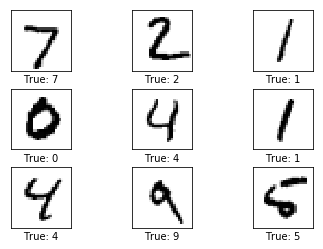

In [9]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images = images, cls_true=cls_true)

### TensorFlow Graph

### Helper-functions for creating new variables

Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

In [12]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### Helper-function for flattening a layer

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [13]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 2-dim tensor of shape [num_images, num_inputs]. The output is a 2-dim tensor of shape [num_images, num_outputs].

In [14]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect x to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead [num_images, img_height, img_width, num_channels]. Note that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [16]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [17]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [18]:
y_true_cls = tf.argmax(y_true, axis=1)

### Convolutional Layer 1
Create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [19]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

Check the shape of the tensor that will be output by the convolutional layer. It is (?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?), each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.

In [21]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolutional Layer 2
Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [22]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

Check the shape of the tensor that will be output from this convolutional layer. The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images, with each image having width and height of 7 pixels, and there are 36 channels, one for each filter.

In [23]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer
The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [24]:
layer_flat, num_features = flatten_layer(layer_conv2)

Check that the tensors now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7 x 7 x 36.

In [25]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [26]:
num_features

1764

### Fully-Connected Layer 1
Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [27]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128.

In [28]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>